In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib as mpl
import seaborn as sns
from graph_tool import GraphView
from graph_tool.draw import sfdp_layout, graph_draw
from sklearn.metrics import average_precision_score
from collections import OrderedDict
from matplotlib import pyplot as plt

from helpers import infected_nodes, cascade_source
from graph_helpers import load_graph_by_name, remove_filters, get_edge_weights, extract_edges, extract_nodes
from random_steiner_tree.util import from_gt
from viz_helpers import lattice_node_pos
from sample_pool import TreeSamplePool
from query_selection import PredictionErrorQueryGenerator, WeightedPredictionErrorQueryGenerator
from simulator import Simulator
from tree_stat import TreeBasedStatistics
from experiment import gen_input
from root_sampler import build_true_root_sampler
from inference import infection_probability

from viz_helpers import visualize, query_plot_setting, default_plot_setting, tree_plot_setting
from eval_helpers import get_scores_by_queries

In [9]:
graph = 'lattice-100'
graph_suffix = '_0.5'
num_queries_to_show = 5
sampling_method = 'loop_erased'
obs_method = "0.2"
cascade_fraction = "0.25"
cascade_model = 'si'
dataset_id = '{}-m{}-s{}-o{}'.format(graph, cascade_model, cascade_fraction, obs_method)
cascade_dir = 'cascade-weighted/{}'.format(dataset_id)
fig_dirname = 'figs/intro'

query_dir = 'outputs/queries-weighted/{}/{}/'.format(dataset_id, sampling_method)
probas_dir = 'outputs/inf_probas-weighted/{}/{}/'.format(dataset_id, sampling_method)


In [44]:
g = load_graph_by_name(graph, weighted=True, suffix=graph_suffix)
ug = GraphView(g, directed=False)
if graph.startswith('lattice'):
    n = int(np.sqrt(g.num_vertices()))
    pos = lattice_node_pos(g, shape=(n, n))
else:
    pos = sfdp_layout(g)

load graph from data/lattice-100/graph_weighted_0.5.gt


In [30]:
cascade_id = 0
obs, c = pkl.load(open('{}/{}.pkl'.format(cascade_dir, cascade_id), 'rb'))[:2]
inf_nodes = infected_nodes(c)
source = cascade_source(c)

In [50]:
node_size_mul = 3.0
edge_width_mul = 3.0

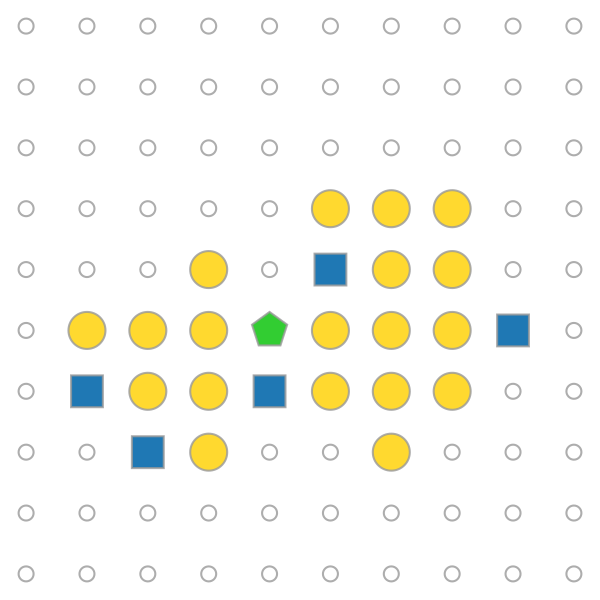

In [59]:
# plot cascade and observations

setting = default_plot_setting(g, c, obs, size_multiplier=node_size_mul)
visualize(g, pos, **setting, output='{}/cascade.pdf'.format(fig_dirname))


In [38]:
gv = remove_filters(g)  # the reserved graph

weights = get_edge_weights(gv)
gi = from_gt(gv, weights=weights)

sampler = TreeSamplePool(
    gv,
    n_samples=100,
    method=sampling_method,
    gi=gi,
    return_type='tuples',
    with_resampling=False,
    with_inc_sampling=False)
sampler.fill(obs, root_sampler=build_true_root_sampler(c))

In [39]:
small_samples = list(sorted(sampler.samples, key=len))

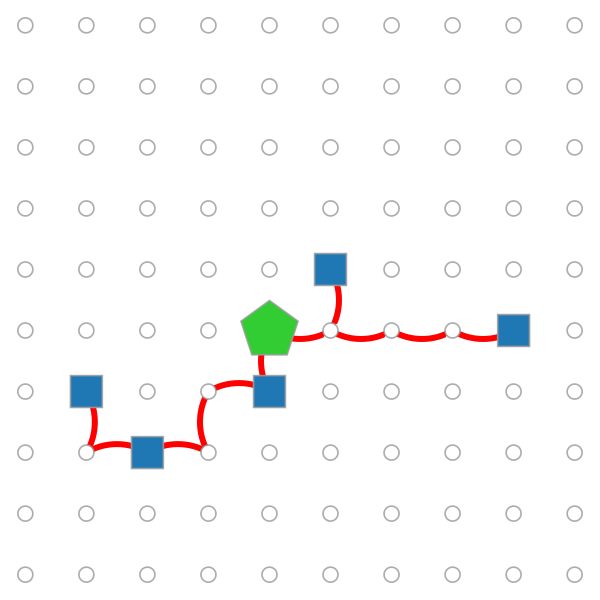

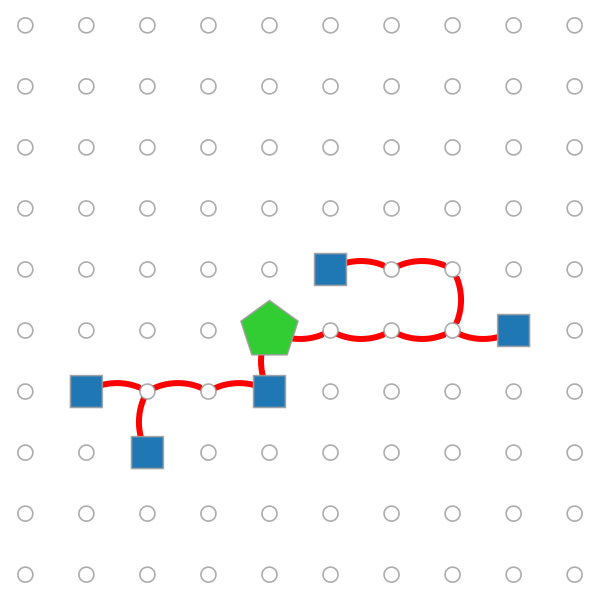

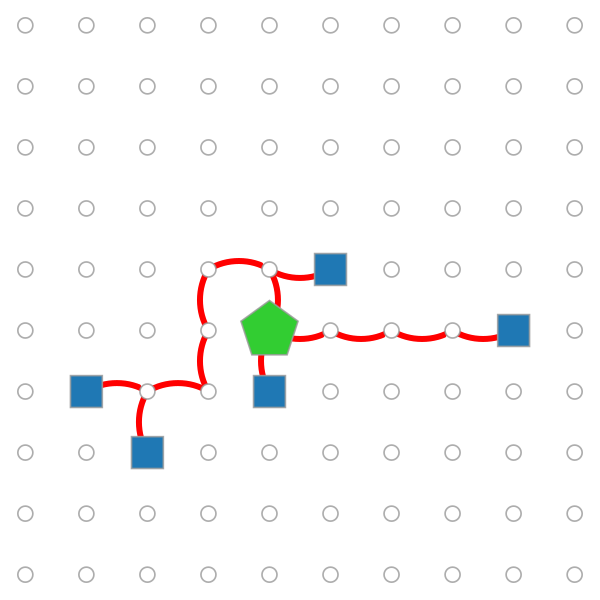

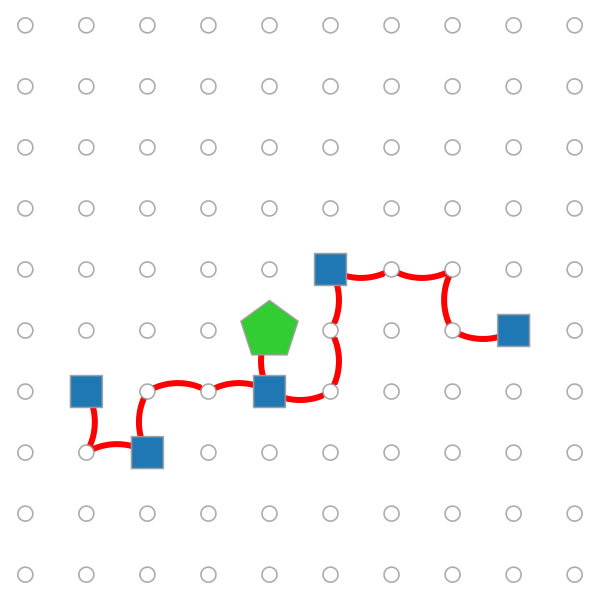

In [60]:
for i, tree in enumerate(small_samples[:4]):
    s = tree_plot_setting(ug, c, obs, tree,
                          size_multiplier=node_size_mul,
                          edge_width_multiplier=edge_width_mul,
                          deemphasize_hidden_infs=True)
    visualize(ug, pos, **s, output="{}/tree-{}.pdf".format(fig_dirname, i))

In [64]:
estimator = TreeBasedStatistics(gv)
probas = infection_probability(g, obs, sampler, estimator)

/home/cloud-user/code/active-network-reconstruction/viz_helpers.py:84: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  del node_color_info['default']


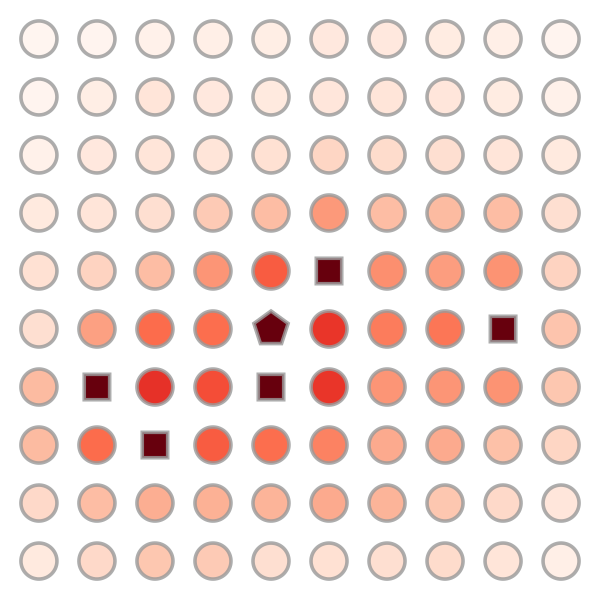

In [94]:
from viz_helpers import InfectionProbabilityViz

viz = InfectionProbabilityViz(g, pos)
hidden_infs = set(inf_nodes) - set(obs)
def f(s):
    # s['node_size_info'][tuple(hidden_infs)] = 20
    pass
viz.plot(c, obs, probas, setting_kwargs={'size_multiplier': node_size_mul * 1.2 },
         output="{}/inf-probas.pdf".format(fig_dirname))

In [85]:
params = {'n_node_samples': None,
          'prune_nodes': True,
          'root_sampler': 'true_root',
          'root_sampler_eps': 0.0,
          'min_proba': 0.05,
          'n_node_samples': None,
          'error_estimator': TreeBasedStatistics(gv)}
q_gen = PredictionErrorQueryGenerator(gv, sampler, **params, verbose=True)
sim = Simulator(gv, q_gen, gi=gi, print_log=True)

In [86]:
n_queries_to_show = 1
qs, _ = sim.run(n_queries_to_show, obs, c)

  0%|          | 0/1 [00:00<?, ?it/s]

pruning candidates from 95 to 39
no estimation node sampling
num. queries reached


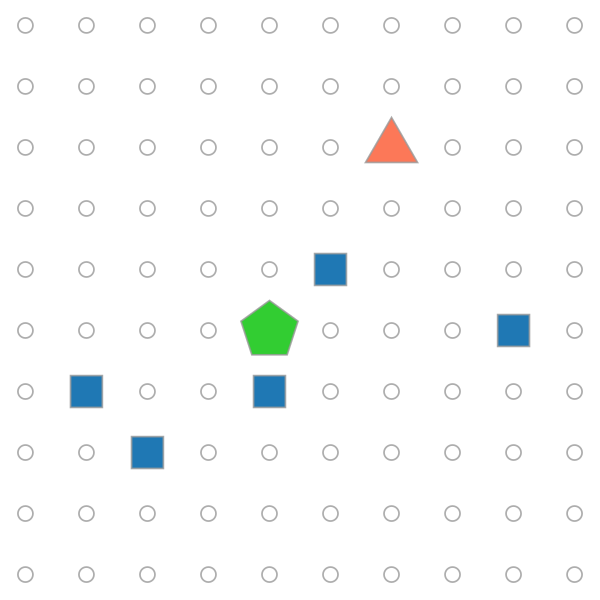

In [96]:
from viz_helpers import COLOR_ORANGE
s = query_plot_setting(g, c, obs, qs[:1], 
                       indicator_type=['color'],
                       size_multiplier=node_size_mul,
                       deemphasize_hidden_infs=True)
s['node_color_info'][tuple(qs)] = COLOR_ORANGE
s['node_size_info'][tuple(qs)] *= node_size_mul
visualize(ug, pos, **s, output="{}/query.pdf".format(fig_dirname))